<a href="https://colab.research.google.com/github/PashaIanko/Robust-Feature-Selection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# Colab
from google.colab import drive

# paths
import os

# data
import pandas as pd

# sklearn
from sklearn.model_selection import train_test_split

# math
import numpy as np

# plotting
from matplotlib import pyplot as plt

# sklearn pipeline & preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

In [2]:
# PEP 8 standard
%%capture 
!pip install pycodestyle 
!pip install --index-url https://test.pypi.org/simple/ nbpep8 
from nbpep8.nbpep8 import pep8

In [3]:
%%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}

git_download_path = \
    'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

files = [
    'sklearn_utils.py',
    'model.py'
]

url_dict = {file: git_download_path + file for file in files}
download_files(url_dict)

In [4]:
import importlib
import sklearn_utils
import model

def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)

reload_all(
    [
        sklearn_utils,
        model
        # other modules
    ]
)

from model import Model
from sklearn_utils import (
    plot_cv_results,
    dict_subset,
    fit_grid_search
)

# Helper functions & constants

In [5]:
TRAINVAL_SIZE = 0.8
TRAIN_SIZE = 0.8  # size(trainval) * train_size
RANDOM_STATE = 42
PSYCHOLOGIC_SAMPLE_SIZE = 0.7

In [47]:
def get_X_Y(df_):
    return df_[:, 1:-1], df_[:, 0]


pep8(_ih)

In [28]:
def plot_insights(df_train_, df_sample_):
    _ = plot_averaged_question_responses(df_train_)

    plot_person_response(
        df_sample_,
        df_indices_=np.unique(df_sample_.index[:5])
    )

    plot_dishonest_responses(df_sample_)


pep8(_ih)

In [315]:
def read_data(root_path, folder_name):
    if folder_name == '5. PHQ9_GAD7':

        phq9_gad_7_csv_path = os.path.join(
            root_path, '5. PHQ9_GAD7', 'PHQ9_GAD7_df.csv')
        assert os.path.isfile(phq9_gad_7_csv_path)
        return pd.read_csv(phq9_gad_7_csv_path, sep=';')

    if folder_name == '2. PRMQ':
        path = os.path.join(
            root_path, '2. PRMQ', 'PRMQ_df.csv')
        assert os.path.isfile(path)
        return pd.read_csv(path, sep=',')

    if folder_name == '3. PCL':
        path = os.path.join(
            root_path, '3. PCL', 'PCL5_df.xlsx'
        )
        assert os.path.isfile(path)
        return pd.read_excel(path)

    if folder_name == '4. NAQ_R':
        path = os.path.join(
            root_path, '4. NAQ_R', 'NAQ_R_df.csv'
        )
        assert os.path.isfile(path)
        df = pd.read_csv(path, sep=';')
        df = df.loc[
            (df['CONDITION'] == 'H')
            | (df['CONDITION'] == 'D'),
            :
        ]
        return df

    if folder_name == '6. PID5':
        path = os.path.join(
            root_path, '6. PID5', 'PID5_df.xlsx')
        print(os.listdir(os.path.join(root_path, '6. PID5')))
        assert os.path.isfile(path)
        return pd.read_excel(path)

    if folder_name == '7. shortPID5':
        path = os.path.join(
            root_path, folder_name, 'sPID-5_df.csv'
        )
        assert os.path.isfile(path)
        return pd.read_csv(path, sep=',')

    if folder_name == '8. PRFQ':
        path = os.path.join(
            root_path, folder_name, 'PRFQ_df.csv'
        )
        assert os.path.isfile(path)
        return pd.read_csv(path, sep=',')

    if folder_name == '9. IESR':
        path = os.path.join(
            root_path, folder_name, 'IESR_df.csv'
        )
        assert os.path.isfile(path)
        return pd.read_csv(path, sep=',')

    if folder_name == '1. shortDT (2)':
        ji_path = os.path.join(
            root_path, folder_name, 'DT_df_JI.csv')
        cc_path = os.path.join(
            root_path, folder_name, 'DT_df_CC.csv')
        assert os.path.isfile(ji_path)
        assert os.path.isfile(cc_path)

        return pd.read_csv(ji_path, sep=';'), \
            pd.read_csv(cc_path, sep=',')

    if folder_name == '13. BF (3)':
        path_ctu = os.path.join(
            root_path, folder_name, 'BF_df_CTU.csv')
        path_ou = os.path.join(
            root_path, folder_name, 'BF_df_OU.csv')
        path_v = os.path.join(
            root_path, folder_name, 'BF_df_V.csv'
        )
        assert os.path.isfile(path_ctu)
        assert os.path.isfile(path_ou)
        assert os.path.isfile(path_v)
        return pd.read_csv(path_ctu, sep=','), \
            pd.read_csv(path_ou, sep=','), \
            pd.read_csv(path_v, sep=',')


pep8(_ih)

In [243]:
def check_data(dataset_):
    # Check is any NAN values
    assert dataset_.isna().sum().sum() == 0

    # Check that all values are in appropriate range
    assert (dataset_.values[:, :-1] <= 5).all() \
        & (dataset_.values[:, :-1] >= 0).all()

In [244]:
def check_split_correctness(df_, target_column_, eps_=0.01):
    '''
    Checks that class balance is still 50%/50%
    '''
    assert abs(df_[target_column_].value_counts(normalize=True)['D'] - 0.5) \
        <= eps_
    assert abs(df_[target_column_].value_counts(normalize=True)['H'] - 0.5) \
        <= eps_


pep8(_ih)

In [245]:
def prepare_sample(
    dataset_,
    sample_size_,
    random_state_=RANDOM_STATE
):
    # Assume the proper structure of the dataset
    # (even number of rows - first honest, then dishonest
    # responses)

    '''
    We split the dataset into 2 halves (of honest and dishonest responses)
    Then generate a sample of random indices, subsample same sample from honest
    half, and dishonest half. And concatenate the samples
    '''

    honest_subset = pd.DataFrame(
        dataset_.loc[: (dataset_.shape[0] / 2) - 1]
    )
    dishonest_subset = pd.DataFrame(
        dataset_.loc[dataset_.shape[0] / 2:]
    )

    dishonest_subset.reset_index(inplace=True)
    dishonest_subset.drop(['index'], axis='columns', inplace=True)

    assert honest_subset.shape[0] == dishonest_subset.shape[0]
    assert honest_subset.shape[0] + dishonest_subset.shape[0] \
        == dataset_.shape[0]
    assert honest_subset.CONDITION.nunique() \
        == dishonest_subset.CONDITION.nunique() \
        == 1
    assert (honest_subset.index == dishonest_subset.index).all()

    np.random.seed(random_state_)

    sample = np.random.choice(
        range(honest_subset.shape[0]),
        replace=False,
        size=int(honest_subset.shape[0] * sample_size_)
    )

    res = pd.concat(
        [
            honest_subset.loc[sample],
            dishonest_subset.loc[sample]
        ]
    )
    assert res.shape[1] \
        == honest_subset.shape[1] \
        == dishonest_subset.shape[1]

    return res


pep8(_ih)

In [246]:
def verify_sample_correctness(df_original_, df_sampled_):
    for i in df_sampled_.index:
        # assert that both Honest and Dishonest conditions are present
        assert len(df_sampled_.index[df_sampled_.index == i]) == 2
        assert 'H' in df_sampled_.loc[i].CONDITION.values \
            and 'D' in df_sampled_.loc[i].CONDITION.values

        # Sample of honest and dishonest response of the same
        # person in original dataset
        original_sample = df_original_.loc[
            [i, int(df_original_.shape[0] / 2) + i]
        ]
        assert (original_sample.values == df_sampled_.loc[i].values).all()


pep8(_ih)

In [247]:
def plot_averaged_question_responses(df_):
    '''
    Assumed structure: target is CONDITION, with H and D values
    1. Splits the dataset into Honest and Dishonest
    2. For each question, computes average score in Honest
    dataset, and Dishonest dataset
    3. Plots the results
    '''

    df_honest = df_[df_['CONDITION'] == 'H']
    df_dishonest = df_[df_['CONDITION'] == 'D']

    result = {}
    for question in df_.columns[df_.columns != 'CONDITION']:
        mean_response_honest = df_honest[question].mean()
        mean_response_dishonest = df_dishonest[question].mean()

        result[question] = {
            'honest': mean_response_honest,
            'dishonest': mean_response_dishonest
        }

    mean_responses_df = pd.DataFrame(result).transpose()

    mean_responses_df['relative_delta'] = \
        (mean_responses_df['dishonest'] - mean_responses_df['honest']) \
        / (mean_responses_df['honest'])

    ax = mean_responses_df.plot(kind='bar')
    ax.set_title(
        'Mean responses in honest and dishonest conditions \n(shuffled people)'
    )
    ax.grid()

    return mean_responses_df


pep8(_ih)

In [248]:
def plot_person_response(df_, df_indices_):
    for df_index in df_indices_:
        ax = df_.loc[
            df_index,
            [c for c in df_.columns if c != 'CONDITION']
        ].transpose().plot(kind='bar')
        ax.legend(df_.loc[df_index, 'CONDITION'])
        ax.set_title(f'Person with index {df_index}')
        ax.grid()


pep8(_ih)

In [249]:
def _visualize_averages(
    df_sample_,
    average_honest_responses,
    average_dishonest_responses,
    average_difference_in_response
):
    ax = pd.DataFrame(
        [
            average_honest_responses,
            average_dishonest_responses,
            average_difference_in_response
        ],
        columns=df_sample_.columns[df_sample_.columns != 'CONDITION'],
        index=['Honest', 'Dishonest', 'Difference']
    ).transpose().plot(kind='bar')

    ax.grid()
    ax.set_title('Average between dishonest and honest responses')
    ax.set_xlabel('Question')
    ax.set_ylabel('Differents in scale')
    ax.legend(loc='lower right')


def plot_dishonest_responses(df_sample_):
    '''
    - Requires input dataframe with the structure,
    like in #5 or #2 dataframes (half of honest, half of
    dishonest rows)
    1. For every person:
        - Collects honest response of this particular person
        - Collects dishonest response of this particular person
        - Collects difference (Dishonest - Honest) for every question
    2. Builds a bar chart, where for each question there are three bars:
        - Average honest response, averaged across all persons
        - Average dishonest response, averaged across all persons
        - Average difference between dishonest and honest response
        (we calculate the difference person-wise --> then take average)
    3. Returns 3 arrays:
        - List of lists of differences in responses
        - List of lists of honest responses
        - List of lists of dishonest responses
    '''

    fig, ax = plt.subplots()
    questions = df_sample_.columns[df_sample_.columns != 'CONDITION']
    unique_person_indices = np.unique(df_sample_.index)
    differences_in_response = []
    honest_responses_array = []
    dishonest_responses_array = []
    plotting_params = dict(marker='o', alpha=0.1)

    for unique_person_index in unique_person_indices:
        # view with Honest and Dishonest responses of the same person
        person_responses = pd.DataFrame(
            df_sample_.loc[unique_person_index])
        honest_responses = person_responses.loc[
            person_responses['CONDITION'] == 'H',
            questions]
        dishonest_responses = person_responses.loc[
            person_responses['CONDITION'] == 'D',
            questions]

        ax.scatter(
            x=range(honest_responses.shape[1]),
            y=honest_responses.values[0],
            color='red',
            **plotting_params
        )

        ax.scatter(
            x=range(honest_responses.shape[1]),
            y=dishonest_responses.values[0],
            color='blue',
            **plotting_params
        )
        differences_in_response.append(
            dishonest_responses.values[0] - honest_responses.values[0])

        honest_responses_array.append(honest_responses.values[0])
        dishonest_responses_array.append(dishonest_responses.values[0])
        del person_responses

    ax.set_xlabel('Questions')
    ax.set_ylabel('Response')
    ax.legend(['Honest', 'Dishonest'], loc='lower right')
    ax.grid()

    # BUILDING ANOTHER PLOT OF DIFFERENCE BETWEEN
    # AVERAGE HONEST AND DISHONEST RESPONSE
    average_difference_in_response = np.mean(
        differences_in_response,
        axis=0)

    average_honest_responses = np.mean(
        honest_responses_array,
        axis=0)

    average_dishonest_responses = np.mean(
        dishonest_responses_array,
        axis=0)

    _visualize_averages(
        df_sample_,
        average_honest_responses,
        average_dishonest_responses,
        average_difference_in_response
    )


pep8(_ih)

In [250]:
def plot_feature_importances(grid_search_results_):
    dataframe_dict = {}
    for model_name, gs_result in grid_search_results_.items():
        dataframe_dict[model_name] = \
            get_feature_importances(
                model_name,
                grid_search_results_[model_name]
            )
    ax = pd.DataFrame(dataframe_dict).plot(kind='bar')
    ax.grid()


def get_feature_importances(
    model_name_,
    grid_search_results_
):
    best_estimator = grid_search_results_.best_estimator_
    if model_name_ == 'SVM':
        return best_estimator.coef_[0]
    elif model_name_ == 'Random forest':
        return best_estimator.feature_importances_


pep8(_ih)

In [261]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from model import Model
from sklearn_utils import plot_cv_results


def plot_problem_statement(df_trainval_):
    # 1. Create data preprocessing pipeline
    target_columns = ['CONDITION']
    target_pipeline = Pipeline(
        [('encode', OrdinalEncoder())])
    preprocessor = ColumnTransformer(
        [
            ('target', target_pipeline, target_columns)
        ],
        remainder='passthrough'
    )

    # 2. Correctly process the data
    df_trainval_processed = preprocessor.fit_transform(df_trainval_)
    X_trainval_processed, Y_trainval_processed = \
        get_X_Y(df_trainval_processed)

    # 3. Define models
    svm_model = Model(
        SVC(),
        'SVM',
        [
            {
                'random_state': [RANDOM_STATE],
                # IMPORTANT! can calc importance only with linear kernel
                'kernel': ['linear']
            }
        ],
        [
            # No specified randomized search parameters
        ]
    )
    random_forest_model = Model(
        RandomForestClassifier(),
        'Random forest',
        [
            {
                'random_state': [RANDOM_STATE]
            }
        ],
        [
            # Not specified
        ]
    )

    all_models = {
        model.name: model
        for model in [
            svm_model,
            random_forest_model
        ]
    }

    # 4. Plot cross validation performance on
    # preprocessed trainval dataset for models
    # with default sklearn parameters
    grid_search_results = fit_grid_search(
        all_models,
        X_=X_trainval_processed,
        Y_=Y_trainval_processed,
        cv_=5,
        scoring_='accuracy'
    )

    cv_res = plot_cv_results(
        {
            model_name: res.best_estimator_
            for model_name, res in grid_search_results.items()
        },
        X_=X_trainval_processed,
        Y_=Y_trainval_processed,
        cv_=5,
        scoring_='accuracy'
    )

    # 5. Plot feature importances
    plot_feature_importances(
        grid_search_results
    )


pep8(_ih)

# Mount drive & set up paths

In [15]:
drive.mount('/content/gdrive')
datasets_folder_path = \
    '/content/gdrive/MyDrive/ML/DataScience_Dataset 2022-2023'

assert os.path.isdir(datasets_folder_path)

Mounted at /content/gdrive


# 1 shortDT

## Read the data

In [252]:
dataset_ji, dataset_cc = read_data(
    datasets_folder_path,
    '1. shortDT (2)'
)

## Quick look and check the data

In [176]:
check_data(dataset_ji)
check_data(dataset_cc)

In [177]:
check_split_correctness(dataset_ji, 'CONDITION')
check_split_correctness(dataset_cc, 'CONDITION')

## Create trainval + test + psychological sets

### Data sampling for the model

In [253]:
from sklearn.model_selection import train_test_split


df_trainval_ji, df_test_ji = train_test_split(
    dataset_ji,
    random_state=RANDOM_STATE,
    train_size=TRAINVAL_SIZE,
    stratify=dataset_ji['CONDITION']
)

[
    check_split_correctness(df, 'CONDITION')
    for df in [df_trainval_ji, df_test_ji]
]

df_trainval_ji.shape, df_test_ji.shape

((691, 28), (173, 28))

In [254]:
df_train_ji, df_val_ji = train_test_split(
    df_trainval_ji,
    random_state=RANDOM_STATE,
    stratify=df_trainval_ji['CONDITION'],
    train_size=TRAIN_SIZE
)

[
    check_split_correctness(df, 'CONDITION')
    for df in [df_train_ji, df_test_ji]
]

df_train_ji.shape, df_test_ji.shape

((552, 28), (173, 28))

In [255]:
df_trainval_cc, df_test_cc = train_test_split(
    dataset_cc,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=dataset_cc['CONDITION']
)

[
    check_split_correctness(df, 'CONDITION')
    for df in [df_trainval_cc, df_test_cc]
]

df_trainval_cc.shape, df_test_cc.shape

((385, 28), (97, 28))

In [256]:
df_train_cc, df_val_cc = train_test_split(
    df_trainval_cc,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval_cc['CONDITION']
)

[
    check_split_correctness(df, 'CONDITION')
    for df in [df_train_cc, df_val_cc]
]

df_train_cc.shape, df_val_cc.shape

((308, 28), (77, 28))

### Data sampling for psychological insights

In [257]:
df_sample_ji = prepare_sample(
    dataset_ji,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset_ji, df_sample_ji)
df_sample_ji.head()

,Mach1,Mach2,Mach3,Mach4,Mach5,Mach6,Mach7,Mach8,Mach9,Psycho1,...,Narc1,Narc2,Narc3,Narc4,Narc5,Narc6,Narc7,Narc8,Narc9,CONDITION
424,4,3,3,3,1,4,4,2,4,1,...,2,3,2,3,3,4,4,4,4,H
75,5,4,2,4,1,2,4,2,2,2,...,4,2,2,3,4,2,2,4,5,H
180,3,2,2,2,3,3,3,3,2,2,...,3,3,2,3,2,3,2,3,4,H
30,4,2,4,4,4,5,4,2,4,1,...,2,4,2,1,4,4,1,3,4,H
392,4,2,3,4,2,4,4,2,2,3,...,3,2,3,3,4,2,4,4,4,H


In [258]:
df_sample_cc = prepare_sample(
    dataset_cc,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset_cc, df_sample_cc)
df_sample_cc.head()

,Mach1,Mach2,Mach3,Mach4,Mach5,Mach6,Mach7,Mach8,Mach9,Psycho1,...,Narc1,Narc2,Narc3,Narc4,Narc5,Narc6,Narc7,Narc8,Narc9,CONDITION
24,4,2,3,3,4,3,3,1,3,4,...,3,3,2,1,2,3,2,2,4,H
6,4,2,2,4,4,4,4,3,4,4,...,4,2,3,3,3,2,2,3,4,H
222,4,2,2,3,2,3,3,3,4,1,...,1,2,2,2,1,2,1,2,4,H
208,4,1,2,2,4,2,4,3,4,1,...,2,2,2,3,3,2,3,2,5,H
236,4,1,3,4,1,2,3,2,1,2,...,3,3,3,3,3,4,3,2,2,H


## Data exploration (on train set only)

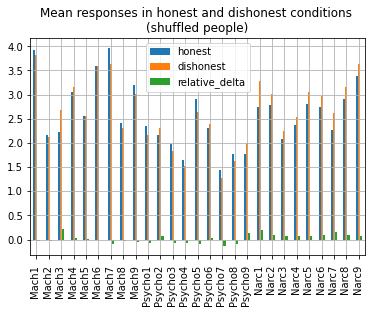

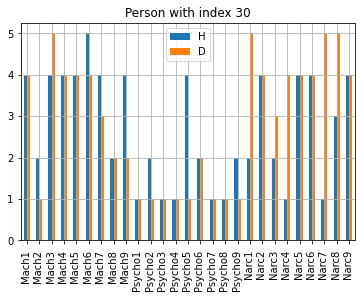

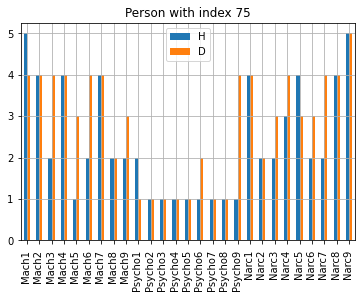

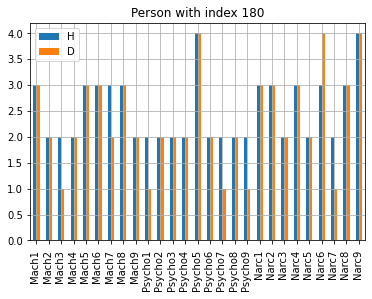

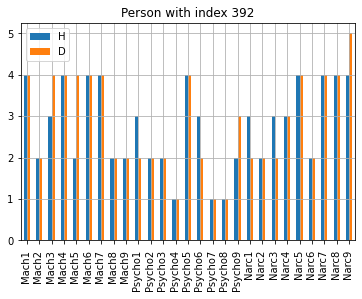

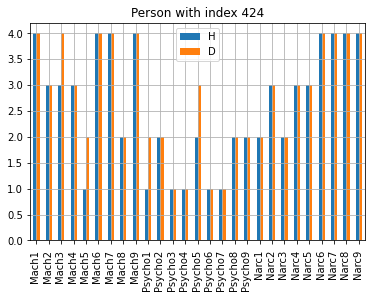

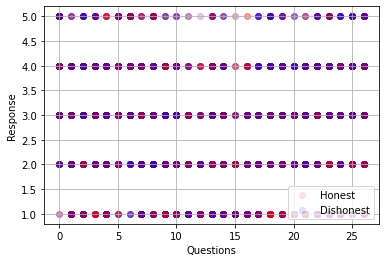

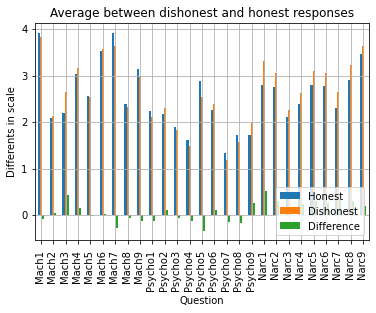

In [184]:
plot_insights(df_train_ji, df_sample_ji)

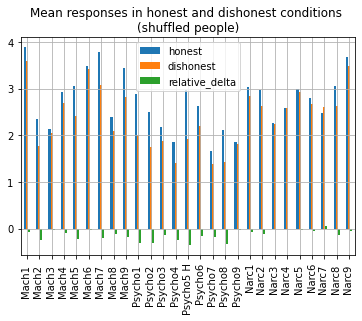

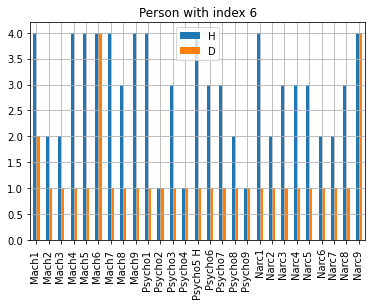

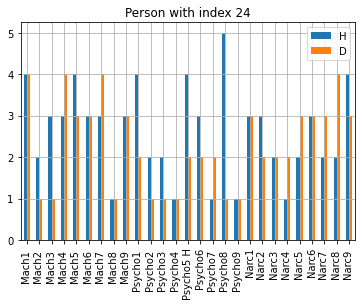

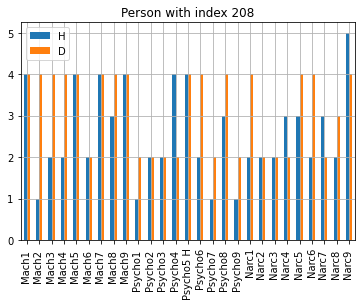

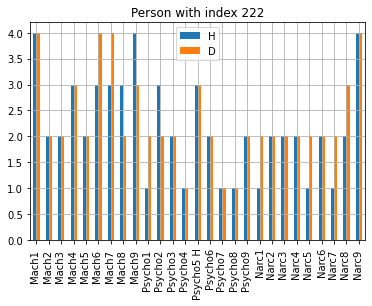

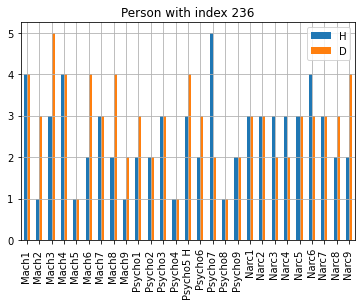

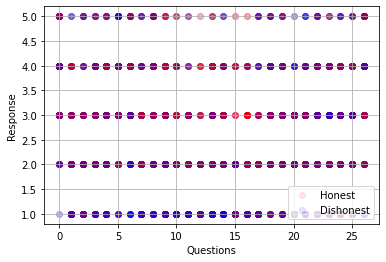

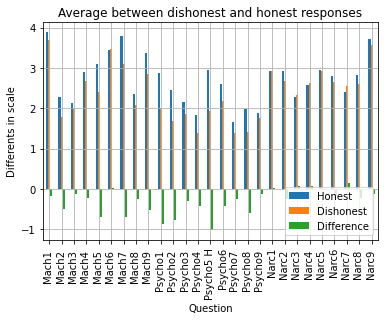

In [32]:
plot_insights(df_train_cc, df_sample_cc)

## Problem statement

Fitting SVM
Fitting Random forest
Model            Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------------  ----------------------  ----------------  ------------------------  ------------------
Random forest                1                0                          0.580304           0.0443102
SVM                          0.698994         0.0109515                  0.668637           0.0351852


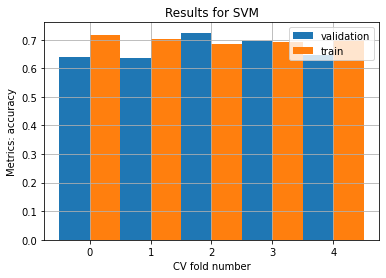

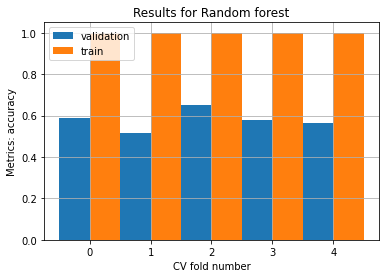

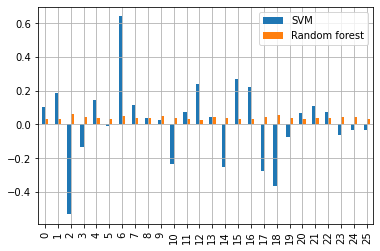

In [262]:
plot_problem_statement(df_trainval_ji)

Fitting SVM
Fitting Random forest
Model            Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------------  ----------------------  ----------------  ------------------------  ------------------
SVM                          0.788961         0.0123206                  0.74026            0.0272418
Random forest                1                0                          0.761039           0.0291558


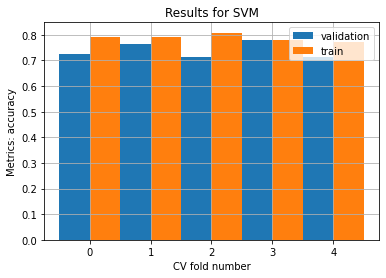

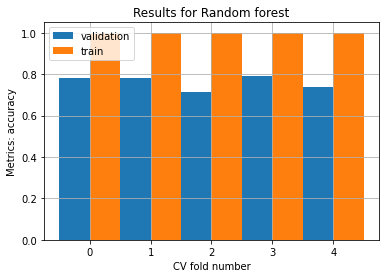

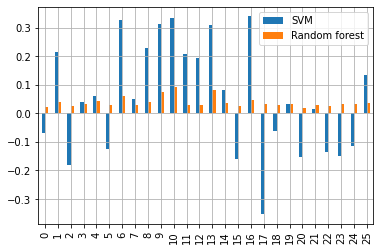

In [263]:
plot_problem_statement(df_trainval_cc)

# 2 PRMQ

## Download the data

In [264]:
dataset = read_data(
    datasets_folder_path,
    '2. PRMQ'
)

dataset.head(1)

,PRMQ_PR_SH_CU1,PRMQ_RE _LO_ENV2,PRMQ_PR_SH_ENV3,PRMQ_RE_SH_CU4,PRMQ_PR_LO_CU5,PRMQ_RE_SH_ENV6,PRMQ_PR_LO_ENV7,PRMQ_RE_LO_CU8,PRMQ_RE_LO_ENV9,PRMQ_PR_SH_ENV10,PRMQ _RE_SH_CU11,PRMQ_PR_LO_ENV12,PRMQ _RE_SH_ENV13,PRMQ _PR_LO_CU14,PRMQ_RE_LO_CU15,PRMQ_PR_SH_CU16,CONDITION
0,4,3,2,4,4,2,3,2,3,3,4,4,2,4,4,4,H


## Quick look and check the data

### Data clean check

In [34]:
check_data(dataset)

### Class balance

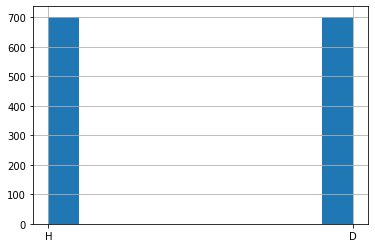

In [35]:
dataset['CONDITION'].hist()

assert len(dataset.loc[dataset['CONDITION'] == 'H', :]) \
    == len(dataset.loc[dataset['CONDITION'] == 'D', :])

## Create trainval + test + psychological sets

### Data sampling for the model

In [265]:
from sklearn.model_selection import train_test_split


df_trainval, df_test = train_test_split(
    dataset,
    random_state=RANDOM_STATE,
    train_size=TRAINVAL_SIZE,
    stratify=dataset['CONDITION']
)

check_split_correctness(df_trainval, 'CONDITION', eps_=0.001)
check_split_correctness(df_test, 'CONDITION', eps_=0.01)

df_trainval.shape, df_test.shape

((1123, 17), (281, 17))

In [266]:
df_train, df_validation = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval['CONDITION']
)


check_split_correctness(df_train, 'CONDITION')
check_split_correctness(df_validation, 'CONDITION')

df_train.shape, df_validation.shape

((898, 17), (225, 17))

### Data sampling for psychological insights

In [267]:
df_sample = prepare_sample(
    dataset,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset, df_sample)
df_sample.head()

,PRMQ_PR_SH_CU1,PRMQ_RE _LO_ENV2,PRMQ_PR_SH_ENV3,PRMQ_RE_SH_CU4,PRMQ_PR_LO_CU5,PRMQ_RE_SH_ENV6,PRMQ_PR_LO_ENV7,PRMQ_RE_LO_CU8,PRMQ_RE_LO_ENV9,PRMQ_PR_SH_ENV10,PRMQ _RE_SH_CU11,PRMQ_PR_LO_ENV12,PRMQ _RE_SH_ENV13,PRMQ _PR_LO_CU14,PRMQ_RE_LO_CU15,PRMQ_PR_SH_CU16,CONDITION
493,5,2,3,3,1,5,4,5,3,5,4,3,1,3,3,5,H
164,2,2,2,2,2,2,3,3,2,2,2,2,1,2,1,2,H
54,3,1,3,3,4,1,4,2,2,2,2,3,1,5,1,4,H
641,1,3,1,1,1,1,1,1,2,1,2,2,1,1,1,1,H
607,1,2,1,1,3,4,1,1,2,2,2,2,1,2,1,1,H


## Data exploration (on train set only)

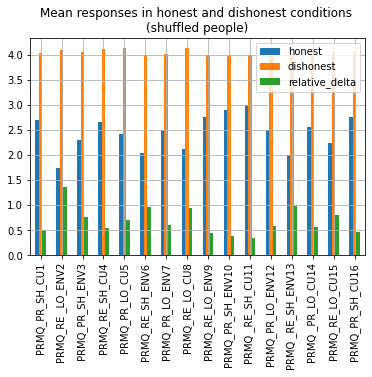

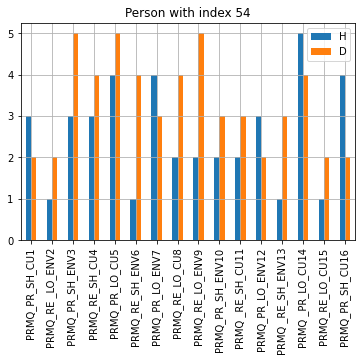

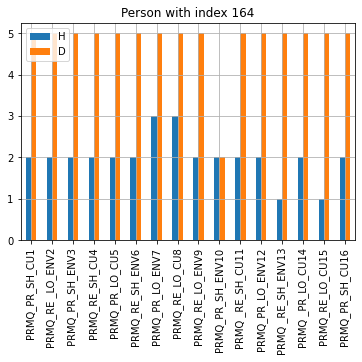

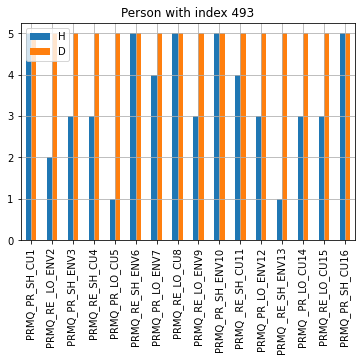

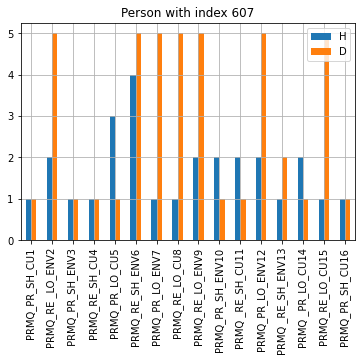

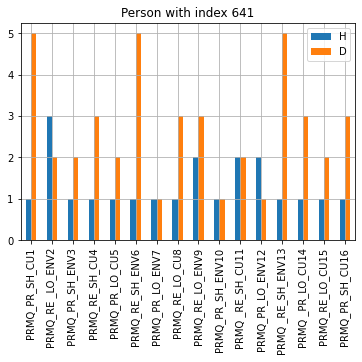

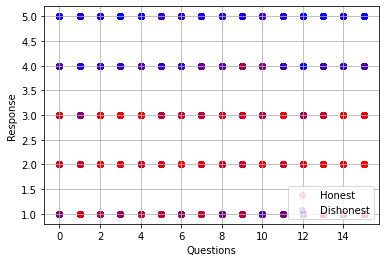

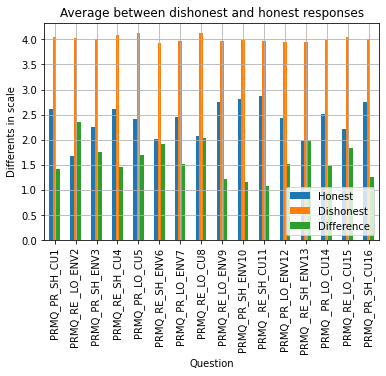

In [39]:
plot_insights(df_train, df_sample)

## Problem statement

Fitting SVM
Fitting Random forest
Model            Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------------  ----------------------  ----------------  ------------------------  ------------------
SVM                          0.906723       0.00239363                   0.89669            0.0156023
Random forest                0.99911        0.000445187                  0.918992           0.0223633


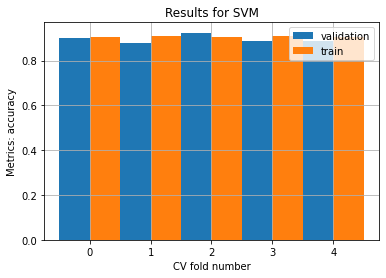

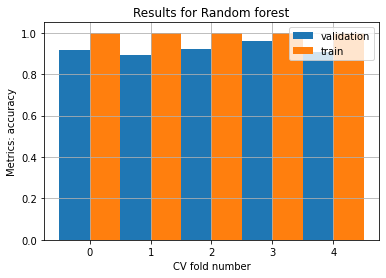

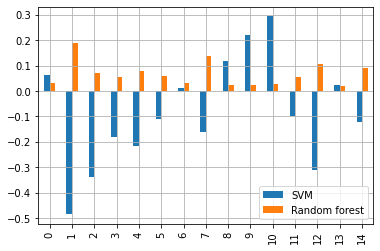

In [268]:
plot_problem_statement(df_trainval)

# 4 NAQ_R

## Download the data

In [269]:
dataset = read_data(
    datasets_folder_path,
    '4. NAQ_R'
)

## Quick look and check the data

### Data clean check

In [94]:
check_data(dataset)

### Class balance

In [95]:
dataset.CONDITION.value_counts()

H    356
D    356
Name: CONDITION, dtype: int64

In [96]:
dataset.shape

(712, 23)

In [97]:
check_split_correctness(dataset, 'CONDITION')

## Create trainval + test + psychological sets

### Data sampling for the model

In [270]:
from sklearn.model_selection import train_test_split


df_trainval, df_test = train_test_split(
    dataset,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=dataset['CONDITION']
)

check_split_correctness(df_trainval, 'CONDITION')
check_split_correctness(df_test, 'CONDITION')

df_trainval.shape, df_test.shape

((569, 23), (143, 23))

In [271]:
df_train, df_validation = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval['CONDITION']
)

check_split_correctness(df_train, 'CONDITION')
check_split_correctness(df_validation, 'CONDITION')

df_train.shape, df_validation.shape

((455, 23), (114, 23))

### Data sampling for psychological insights

In [272]:
df_sample = prepare_sample(
    dataset,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset, df_sample)
df_sample.head()

,NAQ-R_WR_1,NAQ-R_PR_2,NAQ-R_WR_3,NAQ-R_WR_4,NAQ-R_PR_5,NAQ-R_PR_6,NAQ-R_PR_7,NAQ-R_PI_8,NAQ-R_PI_9,NAQ-R_WR_10,...,NAQ-R_PR_14,NAQ-R_PI_15,NAQ-R_WR_16,NAQ-R_PR_17,NAQ-R_WR_18,NAQ-R_WR_19,NAQ-R_PR_20,NAQ-R_WR_21,NAQ-R_PI_22,CONDITION
227,1,1,1,1,2,1,1,2,1,1,...,2,1,2,1,2,2,1,1,1,H
42,1,1,3,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,H
256,3,3,1,1,3,3,1,3,1,1,...,1,1,2,1,1,2,2,2,1,H
182,1,1,4,1,3,1,3,2,1,1,...,3,1,1,3,5,1,1,2,1,H
56,1,1,4,4,1,1,1,1,1,1,...,1,1,2,1,1,1,1,2,1,H


## Data exploration (on train set only)

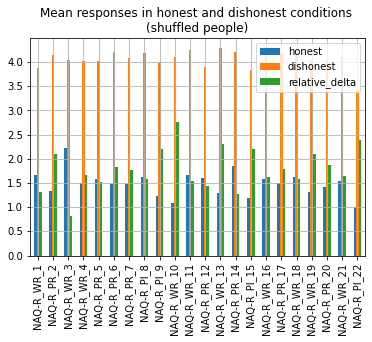

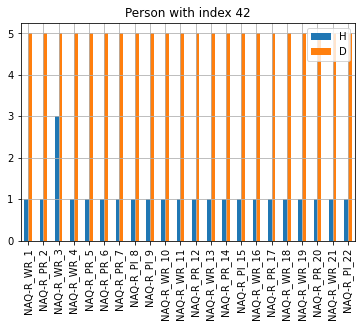

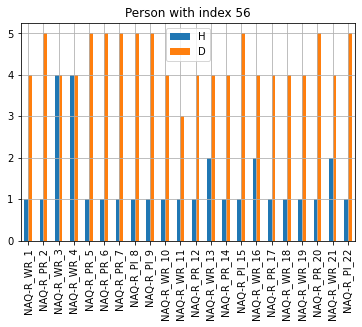

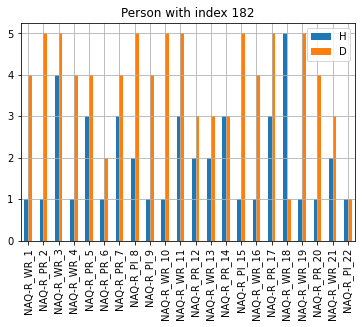

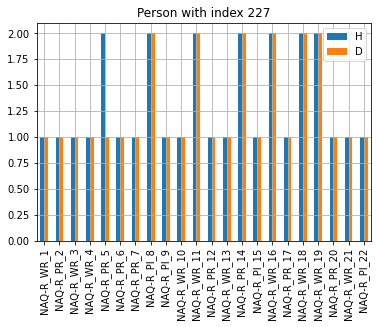

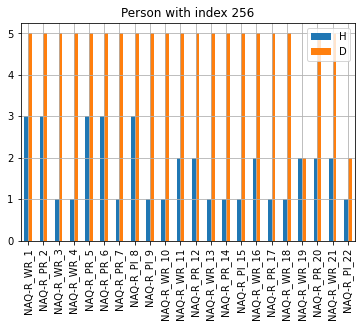

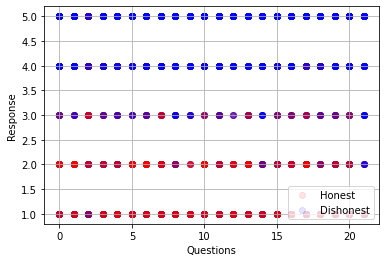

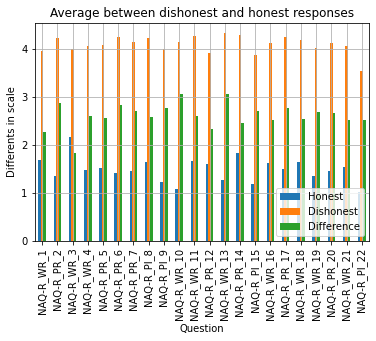

In [101]:
plot_insights(df_train, df_sample)

## Problem statement

Fitting SVM
Fitting Random forest
Model            Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------------  ----------------------  ----------------  ------------------------  ------------------
Random forest                0.988577        0.00255911                  0.943782           0.0162115
SVM                          0.956067        0.00602544                  0.954355           0.0217314


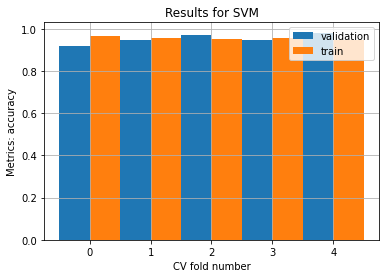

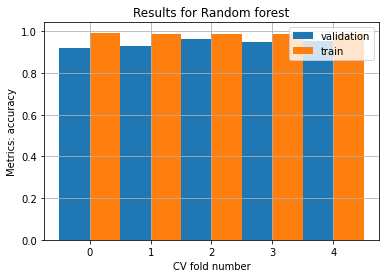

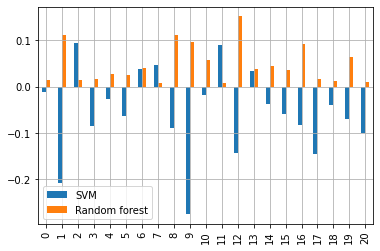

In [273]:
plot_problem_statement(
    df_trainval
)

# 5 PHQ9_GAD7

## Download the data

In [274]:
dataset = read_data(
    datasets_folder_path,
    '5. PHQ9_GAD7'
)

pep8(_ih)

In [275]:
dataset.head()

,PHQ1,PHQ2,PHQ3,PHQ4,PHQ5,PHQ6,PHQ7,PHQ8,PHQ9,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,CONDITION
0,3,1,1,3,1,1,2,1,2,2,3,2,2,2,3,2,H
1,2,1,3,3,1,1,3,1,5,3,3,3,2,1,3,5,H
2,3,2,2,3,4,3,2,2,2,3,2,3,3,3,3,3,H
3,2,2,4,3,2,4,1,4,4,2,4,4,1,1,1,3,H
4,2,2,5,2,4,3,4,2,4,3,2,5,3,1,5,2,H


## Quick look & check the data

In [ ]:
dataset.describe()

,PHQ1,PHQ2,PHQ3,PHQ4,PHQ5,PHQ6,PHQ7,PHQ8,PHQ9,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7
count,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000,1118.000000
mean,3.252236,3.017889,3.538462,3.588551,3.313953,3.164580,2.967800,2.903399,3.265653,3.570662,3.722719,3.700358,3.118068,3.111807,3.445438,3.732558
std,1.470348,1.662597,1.421741,1.329620,1.504634,1.584876,1.649948,1.652855,1.619626,1.387345,1.265209,1.271765,1.586767,1.552721,1.340830,1.353742
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,3.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,3.000000,3.000000,1.000000,2.000000,2.000000,3.000000
50%,3.000000,3.000000,4.000000,4.000000,4.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000,4.000000,4.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


### Data clean check

In [ ]:
check_data(dataset)

### Class balance

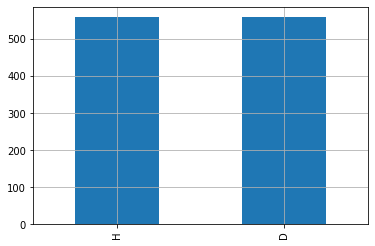

In [ ]:
ax = dataset.CONDITION.value_counts().plot(kind='bar')
ax.grid()

## Create trainval + test + psychological sets

- Use stratified sampling, to support the same class balance in train, validation and test sets
- For training the model (and exploring the data for optimizing the model), we split the dataset into train, validation & test sets with train_test_split function of sklearn (which shuffles the dataset and disrupts the initial structure)
- For gaining psychological insights, we sample the exploration set out of the initial set, **complying with the initial structure** (e.g. if we sample 50% of the dataset --> the sampled data contains honest and dishonest response of the same people, and the structure of the dataset is the same)

### Data sampling for the model

In [281]:
df_trainval, df_test = train_test_split(
    dataset,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=dataset.CONDITION
)

print(df_trainval.shape, df_test.shape)

pep8(_ih)

(894, 17) (224, 17)



In [282]:
df_train, df_validation = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval.CONDITION
)

print(df_train.shape, df_validation.shape)



check_split_correctness(df_train, 'CONDITION')

pep8(_ih)

(715, 17) (179, 17)
cell_content.py:12:1: E303 too many blank lines (3)



### Data sampling for psychological insights

In [278]:
df_sample = prepare_sample(
    dataset,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset, df_sample)
df_sample.head()

,PHQ1,PHQ2,PHQ3,PHQ4,PHQ5,PHQ6,PHQ7,PHQ8,PHQ9,GAD1,GAD2,GAD3,GAD4,GAD5,GAD6,GAD7,CONDITION
158,3,3,4,4,3,2,3,2,1,4,3,4,4,1,4,5,H
451,2,1,2,2,1,2,1,1,1,2,2,1,2,4,2,1,H
55,2,1,4,3,2,1,2,1,5,2,3,2,2,1,3,4,H
247,2,1,2,2,2,1,2,1,1,1,3,3,3,1,1,2,H
70,1,1,2,2,1,1,2,2,5,1,3,2,1,1,2,3,H


## Data exploration (on train set only)

### Insight №1 - Averaged across patients, relative change in response for malinglers is from 46% to 197% (exaggerated)

In [ ]:
_ = plot_averaged_question_responses(df_train)

### Insight №2 - what happens for a concrete person, without averaging? Some people try to fake, others - simply maximize all responses. Tendency to exaggarate is true

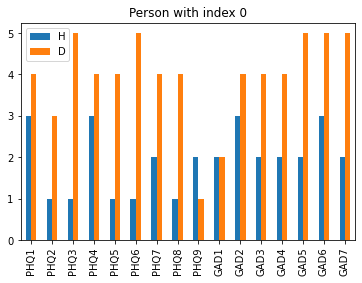

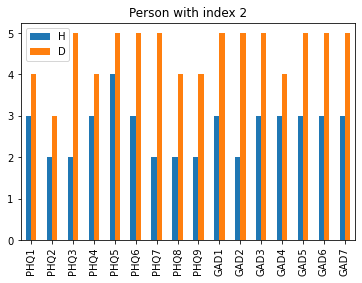

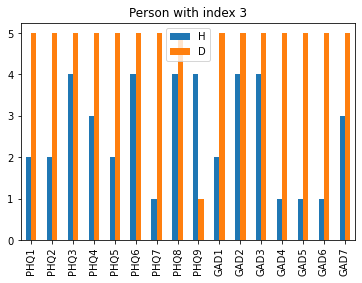

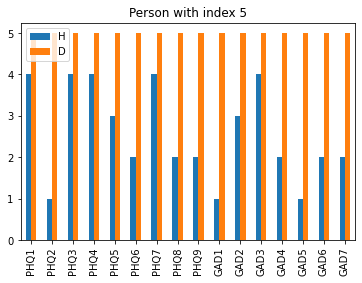

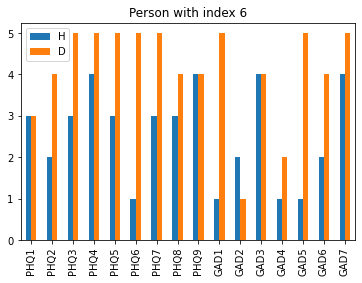

In [ ]:
plot_person_response(
    df_sample,
    np.unique(df_sample.index)[:5]
)

### Insight № 3 - average elevation in dishonest response is around 2-3 points

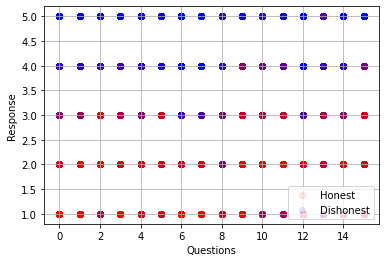

In [ ]:
differences_in_response, honest_responses_array, dishonest_responses_array =\
    plot_dishonest_responses(
        df_sample
    )

In [ ]:
average_difference_in_response = np.mean(
    differences_in_response,
    axis=0
)

average_honest_responses = np.mean(
    honest_responses_array,
    axis=0
)

average_dishonest_responses = np.mean(
    dishonest_responses_array,
    axis=0
)

- Below, you see a bar chart of average difference in responses for the questions. The procedure for obtaining the barchart is:
    - For each question:
        - For each person, collect the difference: (**response_dishonest - response_honest**) 
        - Average across all persons

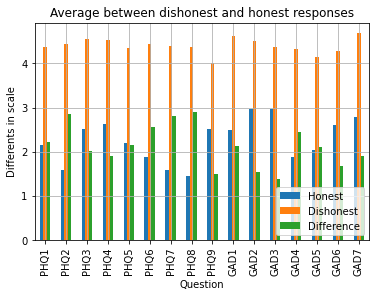

In [ ]:
ax = pd.DataFrame(
    [
        average_honest_responses,
        average_dishonest_responses,
        average_difference_in_response
     ],
    columns=df_sample.columns[df_sample.columns != 'CONDITION'],
    index=['Honest', 'Dishonest', 'Difference']
).transpose().plot(kind='bar')

ax.grid()
ax.set_title('Average between dishonest and honest responses')
ax.set_xlabel('Question')
ax.set_ylabel('Differents in scale')
ax.legend(loc='lower right')

## Problem statement

Fitting SVM
Fitting Random forest
Model            Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------------  ----------------------  ----------------  ------------------------  ------------------
SVM                          0.994966        0.00111976                  0.988808          0.00613709
Random forest                1               0                           0.992166          0.00447875


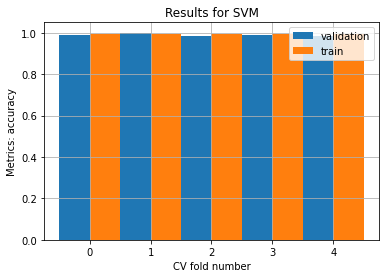

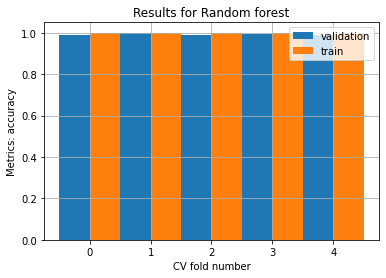

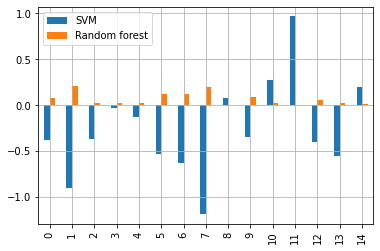

In [284]:
plot_problem_statement(
    df_trainval
)

In [280]:
df_trainval.shape[1]

17

## Data preprocessing

In [ ]:
target_column = 'CONDITION'

question_columns = df_train.columns[
    df_train.columns != target_column
]

# questions_pipeline = Pipeline(
#     []  # empty
# )

target_pipeline = Pipeline(
    [
        ('encode', OrdinalEncoder())  # categories=[['H', 'D']]))
    ]
)

pep8(_ih)

In [ ]:
preprocessor = ColumnTransformer(
    [
        # ('questions', questions_pipeline, question_columns),
        ('target', target_pipeline, [target_column])
    ],
    remainder='passthrough'
)

- Fit & transform on training set
- Only transform on the validation and test sets

In [ ]:
df_train_processed = preprocessor.fit_transform(df_train)
df_validation_processed = preprocessor.transform(df_validation)
df_test_processed = preprocessor.transform(df_test)

In [ ]:
df_trainval_processed = preprocessor.fit_transform(df_trainval)

In [ ]:
X_train_processed, Y_train_processed = \
    get_X_Y(df_train_processed)

X_validation_processed, Y_validation_processed = \
    get_X_Y(df_validation_processed)

X_test_processed, Y_test_processed = \
    get_X_Y(df_test_processed)

X_trainval_processed, Y_trainval_processed = \
    get_X_Y(df_trainval_processed)

## Model selection

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [ ]:
random_forest_model = Model(
    RandomForestClassifier(),
    'Random forest',
    {
        'n_estimators': [1, 2, 5, 10],
        'max_depth': [1, 2, 3],
        'random_state': [RANDOM_STATE],
    },
    {
        'n_estimators': [i for i in range(1, 5)],
        'max_depth': [i for i in range(3)],
        'random_state': [RANDOM_STATE]
    }
)

In [ ]:
svm_model = Model(
    SVC(),
    'SVM',
    {
        'C': [0.1, 0.5, 1.0],
        'kernel': ['linear'],
        'random_state': [RANDOM_STATE]
     
    },
    {
        'C': [i * 0.1 for i in range(1, 11)] + [2, 5],
        'kernel': ['linear'],
        'random_state': [RANDOM_STATE]
    }
)

In [ ]:
all_models = {
    model.name: model
    for model in [
        random_forest_model,
        svm_model
    ]
}

- As we see below, even without fine tuning, models handle the classification task fairly well, reaching 98.7% - 98.9% average accuracy on unseen folds, during cross validation
- Accuracy is a valid metrics, since the classes are balanced
- Thus, **random forest** and **svm classifier** could be shortlisted, if this was a performance-based competition

Model            Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------------  ----------------------  ----------------  ------------------------  ------------------
Random forest                1               0                           0.988814          0.00353336
SVM                          0.994686        0.00104787                  0.989932          0.00224105


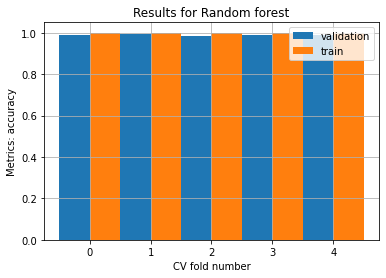

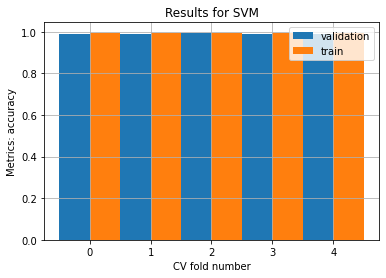

In [ ]:
cv_results = plot_cv_results(
    {name: model.model for name, model in all_models.items()},
    X_=X_trainval_processed,
    Y_=Y_trainval_processed,
    cv_=5,
    scoring_='accuracy'
)

## Model fine-tuning

In [ ]:
grid_search_results = fit_grid_search(
    models_dict_=dict_subset(
        all_models, ['SVM', 'Random forest']
    ),
    X_=X_trainval_processed,
    Y_=Y_trainval_processed,
    cv_=5,
    scoring_='accuracy'
)

Fitting SVM
Fitting Random forest


Model            Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------------  ----------------------  ----------------  ------------------------  ------------------
Random forest                0.9849          0.00323318                  0.978752          0.00219697
SVM                          0.994686        0.00163224                  0.989932          0.00547634


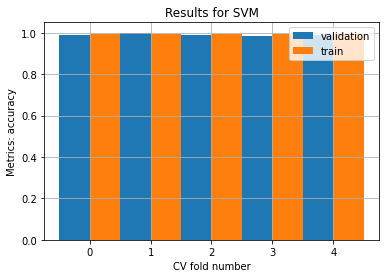

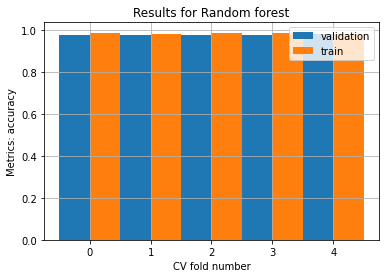

In [ ]:
cv_results = plot_cv_results(
    {name: gs_res.best_estimator_ \
     for name, gs_res in grid_search_results.items()},
    X_=X_trainval_processed,
    Y_=Y_trainval_processed,
    cv_=5,
    scoring_='accuracy'
)

## Problem statement

- Below, we see: despite several models ensure high performance on the unseen data - the high classification preformance is achieved by utilizing different subsets of features

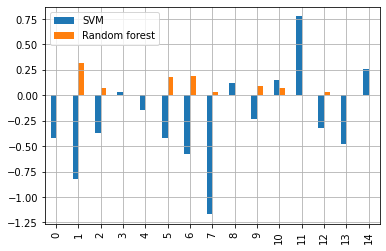

In [ ]:
plot_feature_importances(
    grid_search_results
)

## Solutions for robust feature selection procedure

- Resources:
    - https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/
    - https://machinelearningmastery.com/feature-selection-with-categorical-data/

- Feature selection - is a process of removing **non-informative** or **redundant** predictors
- Therefore, the questions are:
    - What is the **measure of usefulness / informativeness** of a feature?
    - How do different models define informativeness?
    - Why different models select varied subsets of features, that are considered useful?
    

**Feature selection**
- Unsupervised methods:
    - Ignore target variable (don't look at it)
    - Remove redundant predictors (e.g. removing the correlated predictors)
- Supervised methods:
    - Account for target variable
    - Remove irrelavant predictors
- Wrapper methods (e.g. Recursive Feature Elimination)
    - Create many models with different subsets of features, and select the subset, that provides the model with the highest performance
    - **Model-dependent method**
- Filter methods:
    - Uses statistics to evaluate relation between predictors and the target variable. Selects the features with the strongest relationship
    - **Model-independent method**
- Intrinsic feature selection methods:
    - Regards models, capable of internal feature selection during training (e.g. Lasso regression, decision trees)
    - **Model dependent method**
- Dimensionality reduction techniques
    - Instead of selecting features, these techniques *project the data into another space with fewer dimensionality*. We lose the original features.
- **Our conclusion**
    - We will focus on model-independent techniques: filter-based feature selection and dimensionality reduction
    - Since **models cannot be involved into robust feature selection**, we will focus on characteristics, encoding the relationship between predictors and the target variable
    - We will explain why different models select different subsets of meaningful features
    - The target metrics is: difference in classification performance metrics between two cases:
        - Performance, measured for a model, trained on the full dataset
        - Performance, measured for a model, trained on the data with selected features

**Our data**
- Input - categorical ordinal variables, because each has a fixed set of categories (1-5), given in the order of the symptoms' intensity
- Output - categorical binary variable
- According to the *How to choose a feature selection method for ML*, for categorical input and categorical output, the filter-based feature selection methods are:
    - Chi-squared testing
    - Mutual information
- Also, categorical input can be experimentally considered as numerical. This will let us use following methods for numerical input and categorical output:
    - ANOVA correlation coefficient
    - Kendall's rank coefficient

- SelectKBest
- SelectPercentile

- Our experiment scheme:
    1. Find best model, using grid search, on the full training data
    2. Calculate validation performance of the model above
    3. Fit feature selector on training dataset, transform train and validation datasets
    4. Train a model with the same parameters on the train dataset with selected features, and calculate validation metrics on the validation dataset with selected features
    5. Compare validation metrics of the models, trained on full set of features, and dataset with selected features. **Hyperparameters of the model are held the same**. We aim for the smallest difference possible, between these validation performance metrics

### Experiment with Chi-squared feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.base import clone as clone_model

In [ ]:
def perform_feature_selection(
    feature_selection_function_,
    percentile_,
    X_train_,
    Y_train_,
    X_validation_,
    Y_validation_
):
    feature_selector = SelectPercentile(
        score_func=feature_selection_function_,
        percentile=percentile_
    )

    X_train_reduced = feature_selector.fit_transform(X_train_, Y_train_)
    X_validation_reduced = feature_selector.transform(X_validation_)
    return X_train_reduced, X_validation_reduced


pep8(_ih)

In [ ]:
def calculate_validation_performance(
    sklearn_model_,  # grid_search_results_,
    X_train_,
    Y_train_,
    X_validation_,
    Y_validation_,
    metrics_function_,
    feature_selection_function_,
    percentiles_
):
    '''
    percentiles_ - list of percentile values - how much of the features
    we retain.

    '''
    model_before_feature_selection = clone_model(sklearn_model_)
    model_after_feature_selection = clone_model(sklearn_model_)

    # Important - must refit on X_train and Y_train from scratch,
    # because grid search models were refit on X_train + X_validation
    # data, therefore comparison will not be fair
    model_before_feature_selection.fit(X_train_, Y_train_)

    metrics_before_feature_selection = metrics_function_(
        model_before_feature_selection.predict(X_validation_),
        Y_validation_)

    res_metrics = []
    n_features = []
    for percentile in percentiles_:
        X_train_reduced, X_validation_reduced = perform_feature_selection(
            feature_selection_function_,
            percentile,
            X_train_=X_train_,
            Y_train_=Y_train_,
            X_validation_=X_validation_,
            Y_validation_=Y_validation_
        )
        n_features.append(X_train_reduced.shape[1])

        model_after_feature_selection.fit(
            X_train_reduced, Y_train_)
        metrics_after_feature_selection = metrics_function_(
            model_after_feature_selection.predict(X_validation_reduced),
            Y_validation_)
        res_metrics.append(metrics_after_feature_selection)

    return {
        'percentiles': percentiles_,
        'n_features': n_features,
        'metrics': res_metrics
    }


pep8(_ih)

In [ ]:
svm_validation_results = calculate_validation_performance(
    grid_search_results['SVM'].best_estimator_,
    X_train_processed,
    Y_train_processed,
    X_validation_processed,
    Y_validation_processed,
    metrics_function_=accuracy_score,
    feature_selection_function_=chi2,
    percentiles_=[5, 10, 30, 50, 80, 100]
)

svm_validation_results

{'percentiles': [5, 10, 30, 50, 80, 100],
 'n_features': [1, 2, 5, 7, 12, 15],
 'metrics': [0.9553072625698324,
  0.9832402234636871,
  0.9832402234636871,
  0.994413407821229,
  0.9888268156424581,
  0.9832402234636871]}

In [ ]:
random_forest_results = calculate_validation_performance(
    grid_search_results['Random forest'].best_estimator_,
    X_train_processed,
    Y_train_processed,
    X_validation_processed,
    Y_validation_processed,
    metrics_function_=accuracy_score,
    feature_selection_function_=chi2,
    percentiles_=[5, 10, 30, 50, 80, 100]
)

random_forest_results

{'percentiles': [5, 10, 30, 50, 80, 100],
 'n_features': [1, 2, 5, 7, 12, 15],
 'metrics': [0.9553072625698324,
  0.9776536312849162,
  0.9832402234636871,
  0.9832402234636871,
  0.9776536312849162,
  0.9720670391061452]}

In [ ]:
def plot_validation_performance(results_dict_, **kwargs):
    fig, ax = plt.subplots(1, 2, figsize=kwargs.get('figsize') or (15, 5))
    ax2 = ax[0].twiny()
    ax3 = ax[1].twiny()

    ax[0].plot(
        results_dict_['n_features'],
        results_dict_['metrics'],
        marker='o',
        linestyle='--'
    )
    ax[0].set_title('Performance on the validation set')
    ax[0].set_xlabel('Number of retained features')
    ax[0].grid()

    ax[0].axhline(
        results_dict_['metrics'][-1],
        linestyle='--',
        color='red'
    )

    ax[1].plot(
        results_dict_['n_features'],
        [val - results_dict_['metrics'][-1]
         for val in results_dict_['metrics']],
        marker='o',
        linestyle='--'
    )
    ax[1].set_title('Difference between validation performance on' \
                    + '\n reduced and original data')
    ax[1].axhline(
        0,
        linestyle='--',
        color='red'
    )
    ax[1].grid()


pep8(_ih)

cell_content.py:29:68: E502 the backslash is redundant between brackets



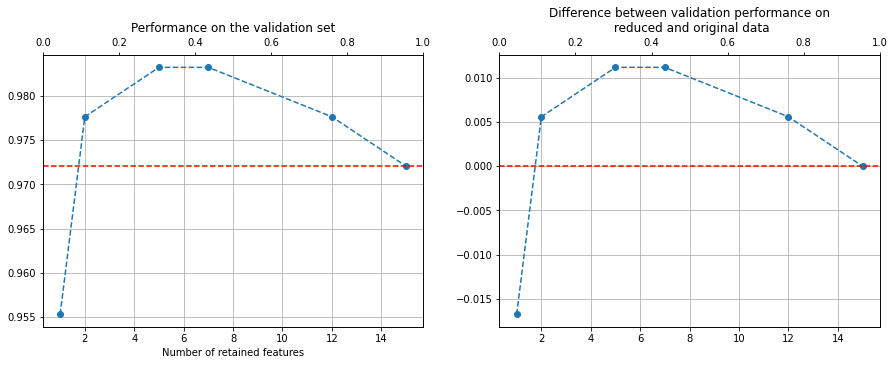

In [ ]:
plot_validation_performance(
    random_forest_results,
    
)

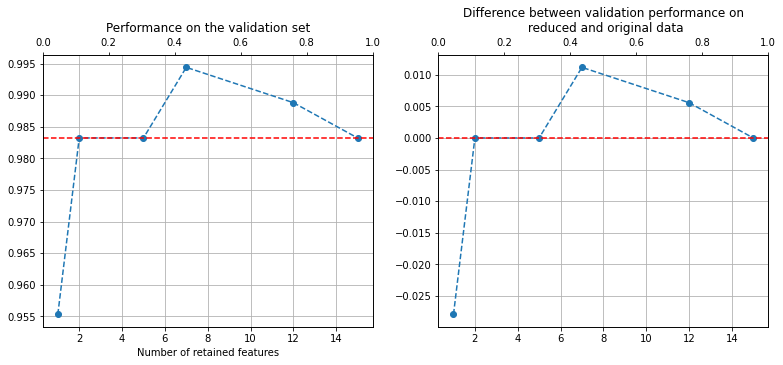

In [ ]:
plot_validation_performance(
    svm_validation_results,
    figsize=(13, 5)
)

In [ ]:
def plot_selector_feature_scores(selector_, name_=''):
    fix, ax = plt.subplots()
    ax.bar(
        np.arange(len(selector_.scores_)),
        selector_.scores_
    )
    ax.set_title(name_)
    ax.grid()


pep8(_ih)

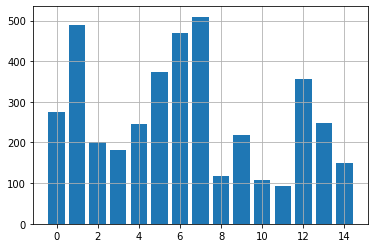

In [ ]:
feature_selector = SelectPercentile(
    score_func=chi2,
    percentile=100
)

feature_selector.fit(X_train_processed, Y_train_processed)
plot_selector_feature_scores(feature_selector)

# 6 PID5

## Download the data

In [285]:
dataset = read_data(
    datasets_folder_path,
    '6. PID5'
)

['PID-5_test.pdf', 'PID5_df (1).gsheet', 'PID5_df.gsheet', 'PID5_df.xlsx', 'PID_5_Description.docx']


In [286]:
# PROBLEM HERE!!!
dataset.head(1)

,Q1;Q2;Q3;Q4;Q5;Q6;Q7;Q8;Q9;Q10;Q11;Q12;Q13;Q14;Q15;Q16;Q17;Q18;Q19;Q20;Q21;Q22;Q23;Q24;Q25;Q26;Q27;Q28;Q29;Q30;Q31;Q32;Q33;Q34;Q35;Q36;Q37;Q38;Q39;Q40;Q41;Q42;Q43;Q44;Q45;Q46;Q47;Q48;Q49;Q50;Q51;Q52;Q53;Q54;Q55;Q56;Q57;Q58;Q59;Q60;Q61;Q62;Q63;Q64;Q65;Q66;Q67;Q68;Q69;Q70;Q71;Q72;Q73;Q74;Q75;Q76;Q77;Q78;Q79;Q80;Q81;Q82;Q83;Q84;Q85;Q86;Q87;Q88;Q89;Q90;Q91;Q92;Q93;Q94;Q95;Q96;Q97;Q98;Q99;Q100;Q101;Q102;Q103;Q104;Q105;Q106;Q107;Q108;Q109;Q110;Q111;Q112;Q113;Q114;Q115;Q116;Q117;Q118;Q119;Q120;Q121;Q122;Q123;Q124;Q125;Q126;Q127;Q128;Q129;Q130;Q131;Q132;Q133;Q134;Q135;Q136;Q137;Q138;Q139;Q140;Q141;Q142;Q143;Q144;Q145;Q146;Q147;Q148;Q149;Q150;Q151;Q152;Q153;Q154;Q155;Q156;Q157;Q158;Q159;Q160;Q161;Q162;Q163;Q164;Q165;Q166;Q167;Q168;Q169;Q170;Q171;Q172;Q173;Q174;Q175;Q176;Q177;Q178;Q179;Q180;Q181;Q182;Q183;Q184;Q185;Q186;Q187;Q188;Q189;Q190;Q191;Q192;Q193;Q194;Q195;Q196;Q197;Q198;Q199;Q200;Q201;Q202;Q203;Q204;Q205;Q206;Q207;Q208;Q209;Q210;Q211;Q212;Q213;Q214;Q215;Q216;Q217;Q218;Q219;Q220;CONDITION
0,0;0;2;2;0;0;2;0;0;1;0;0;1;1;1;2;0;1;0;1;0;2;0;...


# 7 Short PID 5

## Download the data

In [287]:
dataset = read_data(
    datasets_folder_path,
    '7. shortPID5'
)

## Quick look and check the data

### Data clean check

In [ ]:
check_data(dataset)

### Class balance

In [ ]:
check_split_correctness(dataset, 'CONDITION')

## Create trainval + test + psychological sets

### Data sampling for the model

In [288]:
from sklearn.model_selection import train_test_split


df_trainval, df_test = train_test_split(
    dataset,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=dataset['CONDITION']
)

check_split_correctness(df_trainval, 'CONDITION')
check_split_correctness(df_test, 'CONDITION')

df_trainval.shape, df_test.shape

((830, 26), (208, 26))

In [289]:
df_train, df_val = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval['CONDITION']
)

[check_split_correctness(df_, 'CONDITION') for df_ in [df_train, df_val]]

[None, None]

### Data sampling for psychological insights

In [290]:
df_sample = prepare_sample(
    dataset,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset, df_sample)
df_sample.head()

,PID1,PID2,PID3,PID4,PID5,PID6,PID7,PID8,PID9,PID10,...,PID17,PID18,PID19,PID20,PID21,PID22,PID23,PID24,PID25,CONDITION
275,1,2,2,3,3,4,4,3,3,1,...,1,2,3,1,4,2,3,1,3,H
93,1,1,1,3,1,2,1,3,4,3,...,1,1,2,3,1,1,1,1,1,H
6,2,3,2,3,2,1,3,2,4,2,...,1,2,3,3,4,3,3,1,3,H
167,2,2,1,1,1,1,1,3,2,2,...,1,2,2,1,1,1,1,1,1,H
90,1,1,1,1,1,2,1,2,3,1,...,1,1,1,1,1,1,1,1,1,H


## Data exploration (with train set only)

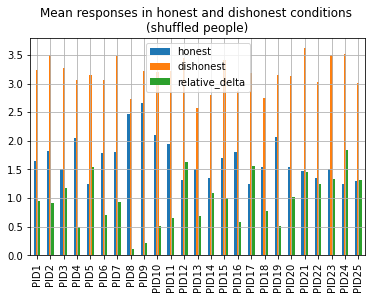

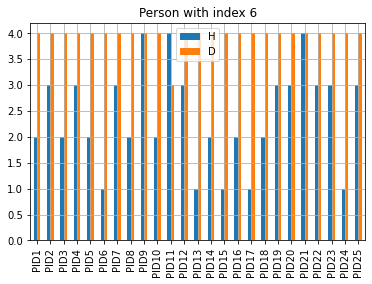

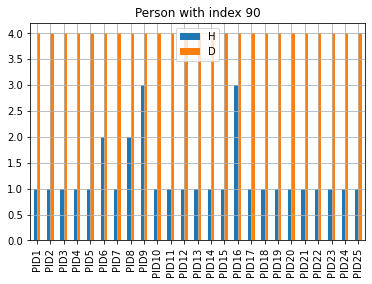

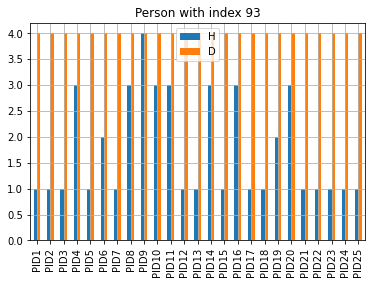

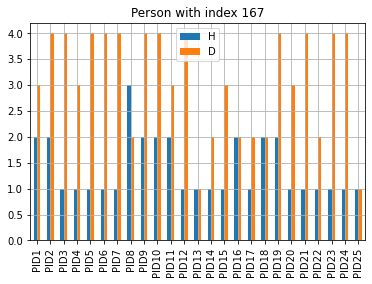

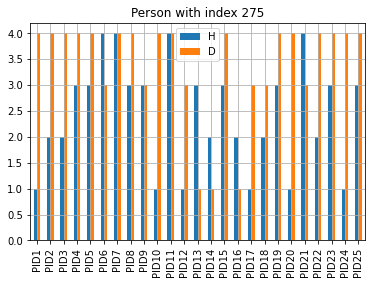

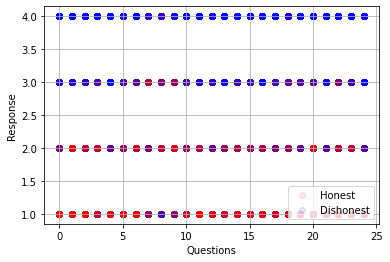

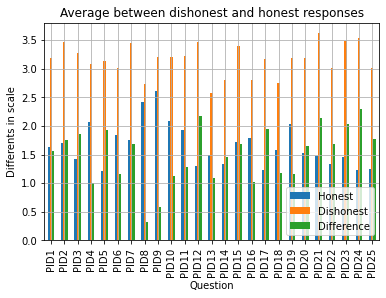

In [ ]:
plot_insights(df_train, df_sample)

## Problem statement

Fitting SVM
Fitting Random forest
Model            Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------------  ----------------------  ----------------  ------------------------  ------------------
SVM                          0.970482        0.00591774                  0.956627           0.019576
Random forest                1               0                           0.96747            0.0124044


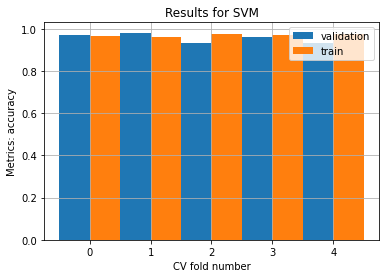

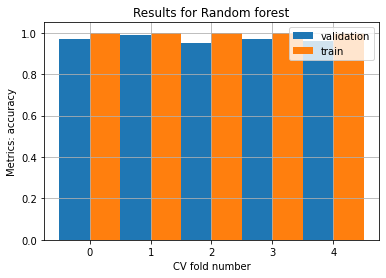

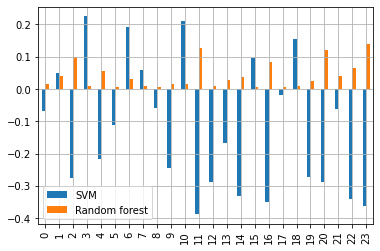

In [291]:
plot_problem_statement(df_trainval)

# 8 PRFQ

## Download the data

In [293]:
dataset = read_data(
    datasets_folder_path,
    '8. PRFQ'
)
dataset.shape

(678, 19)

## Quick look and check the data

In [ ]:
check_data(dataset)

In [ ]:
check_split_correctness(dataset, 'CONDITION')

## Create trainval + test + pspychological sets

In [294]:
from sklearn.model_selection import train_test_split


df_trainval, df_test = train_test_split(
    dataset,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=dataset['CONDITION']
)

check_split_correctness(df_trainval, 'CONDITION')
check_split_correctness(df_test, 'CONDITION')

df_trainval.shape, df_test.shape

((542, 19), (136, 19))

In [295]:
df_train, df_val = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval['CONDITION']
)

[check_split_correctness(df, 'CONDITION') for df in [df_train, df_val]]

[None, None]

In [296]:
df_sample = prepare_sample(
    dataset,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset, df_sample)
df_sample.head()

,PreM1,PreM2,PreM3,PreM4,PreM5,PreM6,C1,C2,C3,C4,C5,C6,IC1,IC2,IC3,IC4,IC5,IC6,CONDITION
284,1,1,1,1,1,2,4,3,4,5,4,4,5,3,5,4,5,5,H
116,1,1,1,1,1,5,3,1,1,5,4,3,2,4,4,1,5,3,H
113,5,1,2,1,1,4,4,4,5,3,5,3,4,4,5,5,5,5,H
42,1,1,1,1,1,1,2,1,3,3,1,1,5,4,5,5,3,3,H
126,2,1,4,1,2,2,3,3,3,2,4,2,5,5,5,5,5,5,H


## Data exploration (with train set only)

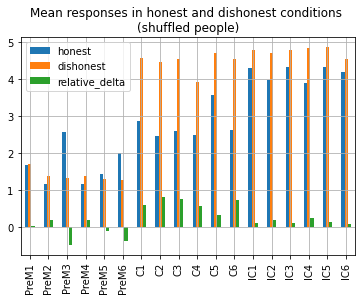

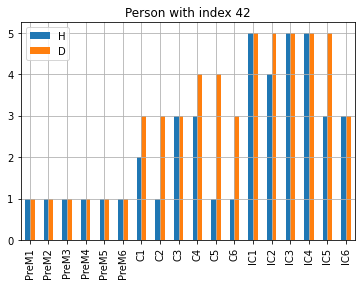

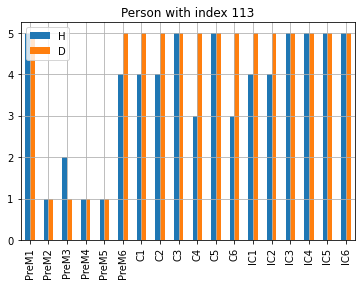

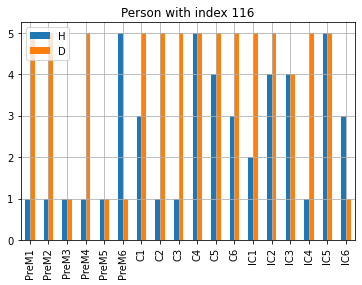

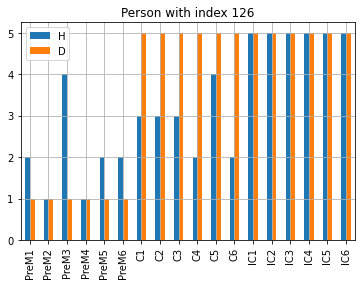

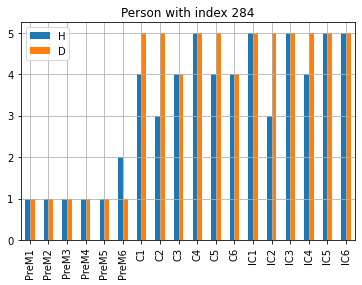

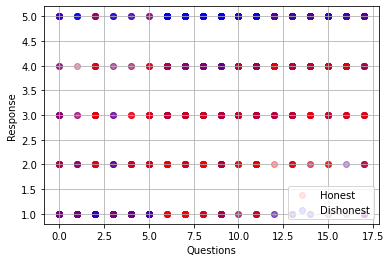

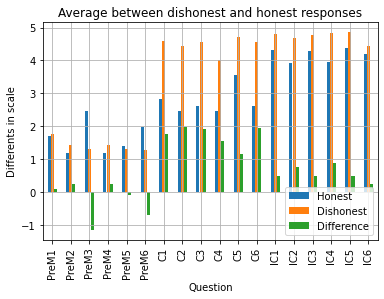

In [ ]:
plot_insights(df_train, df_sample)

## Problem statement

Fitting SVM
Fitting Random forest
Model            Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------------  ----------------------  ----------------  ------------------------  ------------------
SVM                          0.928508        0.00523522                  0.900408           0.0195483
Random forest                1               0                           0.920676           0.0257758


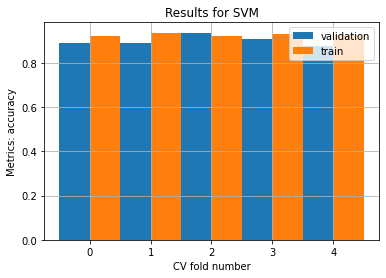

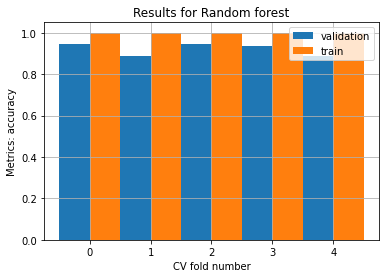

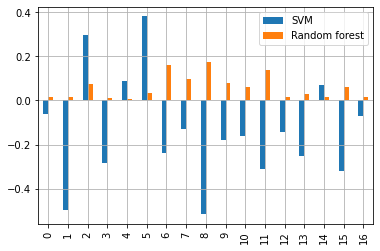

In [297]:
plot_problem_statement(df_trainval)

# 9 IESR

## Download the data

In [298]:
dataset = read_data(
    datasets_folder_path,
    '9. IESR'
)

## Quick look and check the data

In [ ]:
check_data(dataset)

In [ ]:
check_split_correctness(dataset, 'CONDITION')

## Create trainval + test + psychological sets

In [299]:
from sklearn.model_selection import train_test_split


df_trainval, df_test = train_test_split(
    dataset,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=dataset['CONDITION']
)

[check_split_correctness(df, 'CONDITION') for df in (df_trainval, df_test)]

df_trainval.shape, df_test.shape

((286, 23), (72, 23))

In [300]:
df_train, df_val = train_test_split(
    df_trainval,
    random_state=RANDOM_STATE,
    train_size=TRAIN_SIZE,
    stratify=df_trainval['CONDITION']
)

[check_split_correctness(df, 'CONDITION') for df in (df_train, df_val)]
df_train.shape, df_val.shape

((228, 23), (58, 23))

In [301]:
df_sample = prepare_sample(
    dataset,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset, df_sample)
df_sample.head()

,IESR1,IESR2,IESR3,IESR4,IESR5,IESR6,IESR7,IESR8,IESR9,IESR10,...,IESR14,IESR15,IESR16,IESR17,IESR18,IESR19,IESR20,IESR21,IESR22,CONDITION
78,3,2,2,3,2,1,1,1,1,2,...,1,1,5,1,3,2,1,1,1,H
16,1,1,1,2,1,2,1,1,1,1,...,1,2,1,1,2,1,1,1,1,H
65,1,1,1,2,1,1,1,3,1,3,...,1,3,1,4,1,1,1,1,1,H
114,3,2,3,3,2,3,2,2,2,2,...,1,1,3,3,2,1,2,1,2,H
76,3,1,2,2,2,2,1,2,2,2,...,1,2,3,1,2,1,2,3,1,H


## Data exploration (on train set only)

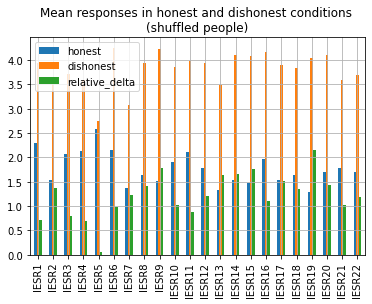

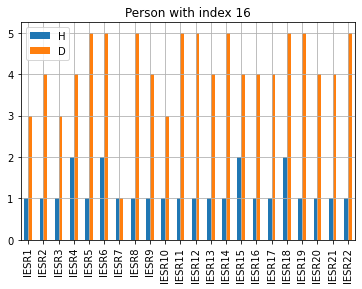

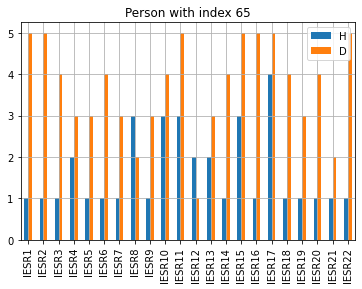

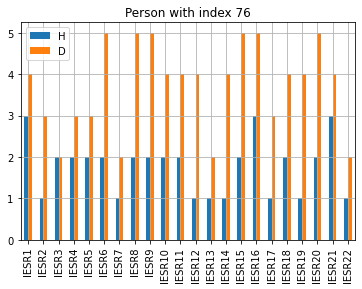

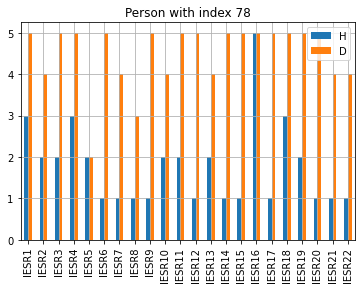

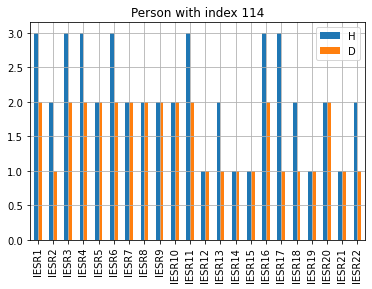

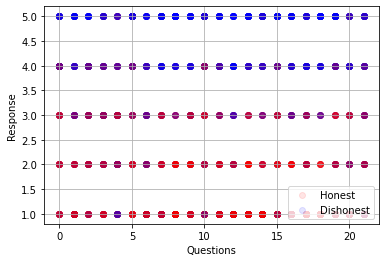

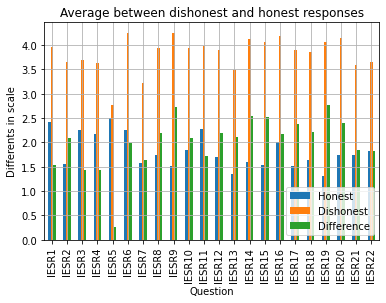

In [ ]:
plot_insights(df_train, df_sample)

## Problem statement

Fitting SVM
Fitting Random forest
Model            Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------------  ----------------------  ----------------  ------------------------  ------------------
SVM                           0.95018        0.00342662                  0.905687           0.0321828
Random forest                 1              0                           0.926739           0.0294985


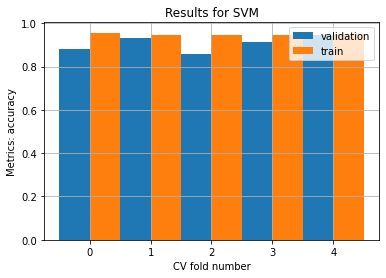

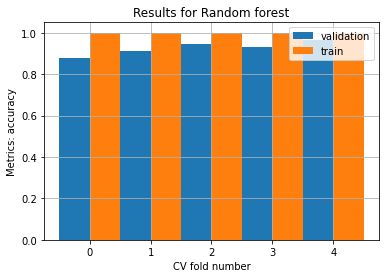

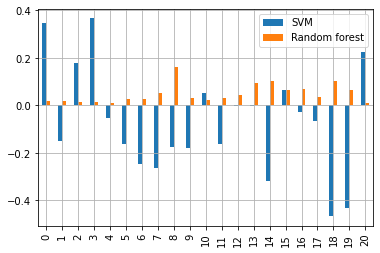

In [302]:
plot_problem_statement(df_trainval)

# 13 BF (3)

## Download the data

In [318]:
df_ctu, df_ou, df_v = read_data(
    datasets_folder_path,
    '13. BF (3)'
)

## Quick look and check the data

In [319]:
check_data(df_ctu)
check_data(df_ou)
check_data(df_v)

In [321]:
[
    check_split_correctness(df, 'CONDITION')
    for df in [df_ctu, df_ou, df_v]
]

[None, None, None]

## Create trainval + test + psychological sets

In [325]:
from sklearn.model_selection import train_test_split


df_trainval_ctu, df_test_ctu = train_test_split(
    df_ctu,
    random_state=RANDOM_STATE,
    train_size=TRAINVAL_SIZE,
    stratify=df_ctu.CONDITION
)

df_trainval_ou, df_test_ou = train_test_split(
    df_ou,
    random_state=RANDOM_STATE,
    train_size=TRAINVAL_SIZE,
    stratify=df_ou.CONDITION
)

df_trainval_v, df_test_v = train_test_split(
    df_v,
    random_state=RANDOM_STATE,
    train_size=TRAINVAL_SIZE,
    stratify=df_v.CONDITION
)

[
    check_split_correctness(df, 'CONDITION')
    for df in [
        df_trainval_ctu, df_test_ctu,
        df_trainval_ou, df_test_ou,
        df_trainval_v, df_test_v
    ]
]

print(df_trainval_ctu.shape, df_test_ctu.shape)
print(df_trainval_ou.shape, df_test_ou.shape)
print(df_trainval_v.shape, df_test_v.shape)

(353, 11) (89, 11)
(368, 11) (92, 11)
(388, 11) (98, 11)


In [327]:
df_train_ctu, df_validation_ctu = train_test_split(
    df_trainval_ctu,
    random_state=RANDOM_STATE,
    train_size=TRAIN_SIZE,
    stratify=df_trainval_ctu.CONDITION
)

df_train_ou, df_validation_ou = train_test_split(
    df_trainval_ou,
    random_state=RANDOM_STATE,
    train_size=TRAIN_SIZE,
    stratify=df_trainval_ou.CONDITION
)

df_train_v, df_validation_v = train_test_split(
    df_trainval_v,
    random_state=RANDOM_STATE,
    train_size=TRAIN_SIZE,
    stratify=df_trainval_v.CONDITION
)

[
    check_split_correctness(df, 'CONDITION')
    for df in [
        df_train_ctu, df_validation_ctu,
        df_train_ou, df_validation_ou,
        df_train_v, df_validation_v
    ]
]

print(df_train_ctu.shape, df_validation_ctu.shape)
print(df_train_ou.shape, df_validation_ou.shape)
print(df_train_v.shape, df_validation_v.shape)

(282, 11) (71, 11)
(294, 11) (74, 11)
(310, 11) (78, 11)


In [328]:
df_sample_ctu = prepare_sample(
    df_ctu,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(df_ctu, df_sample_ctu)
df_sample_ctu.head()

,EX1G,EX2G,A1G,A2G,C1G,C2G,ES1G,ES2G,O1G,O2G,CONDITION
132,5,3,3,1,2,5,5,3,2,3,H
148,4,4,3,4,1,5,2,1,2,2,H
93,5,3,3,2,3,4,3,3,4,4,H
180,4,2,3,4,4,4,4,4,4,3,H
15,4,3,3,3,3,4,3,3,2,4,H


In [329]:
df_sample_ou = prepare_sample(
    df_ou,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(df_ou, df_sample_ou)

df_sample_v = prepare_sample(
    df_v,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(df_v, df_sample_v)

## Data exploration (on train set only)

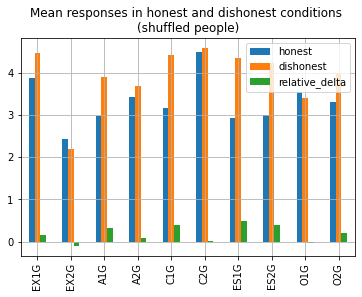

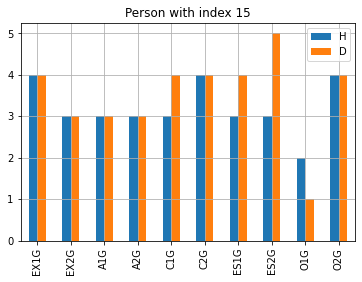

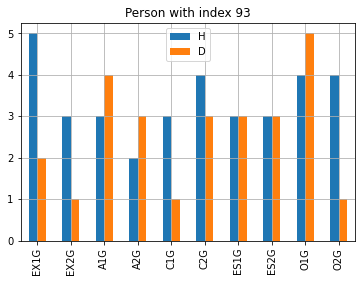

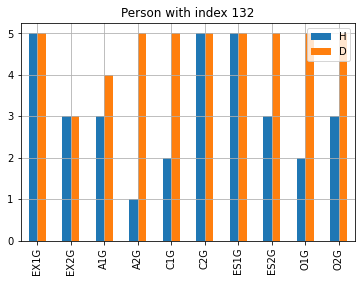

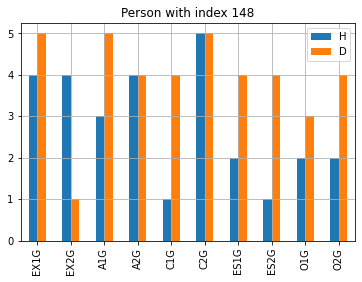

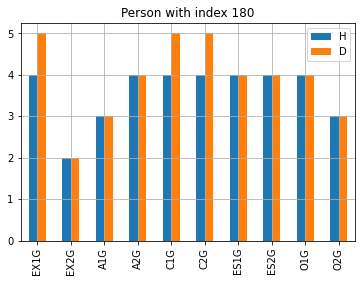

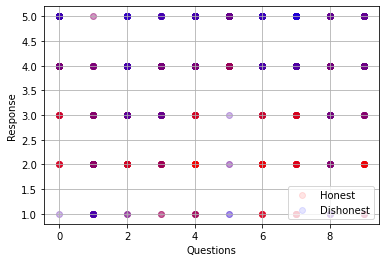

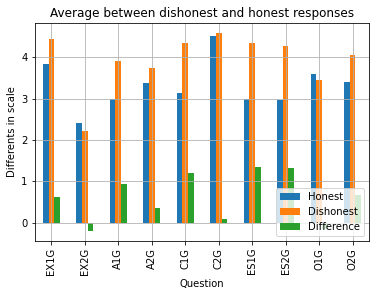

In [330]:
plot_insights(df_ctu, df_sample_ctu)

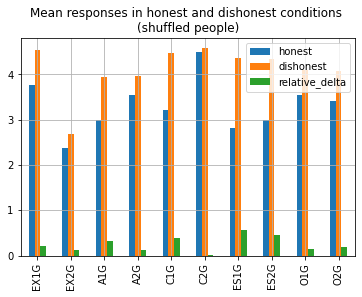

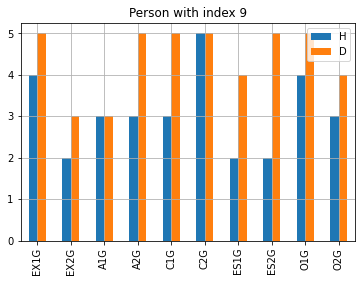

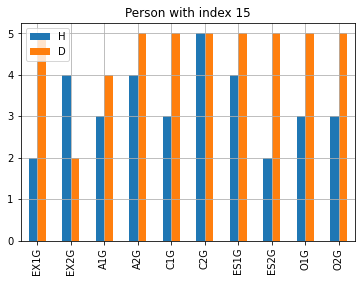

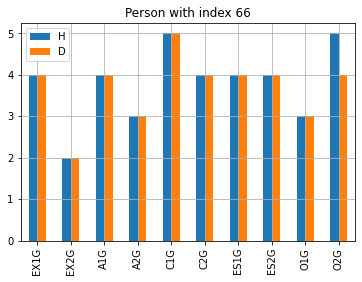

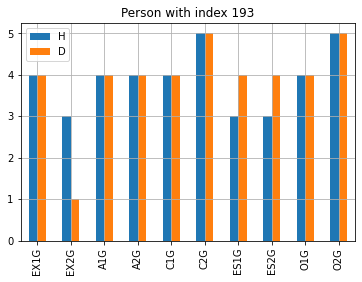

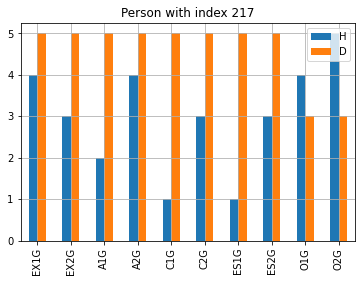

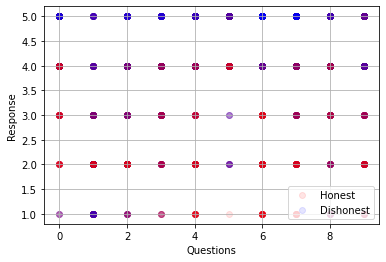

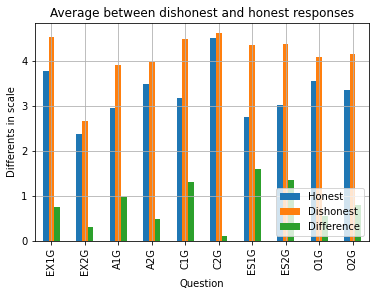

In [331]:
plot_insights(df_ou, df_sample_ou)

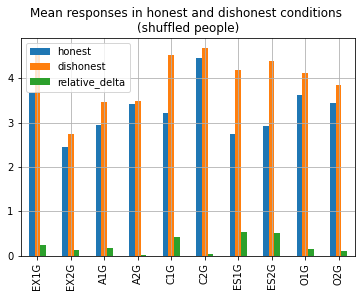

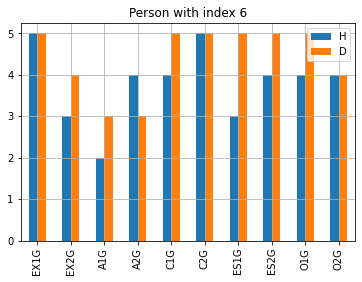

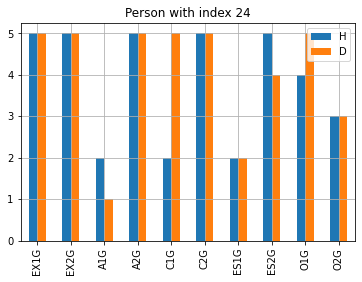

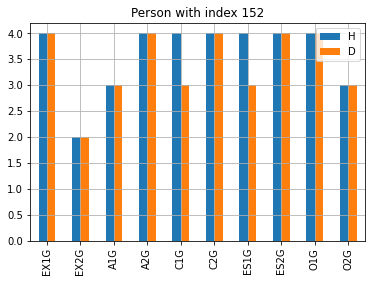

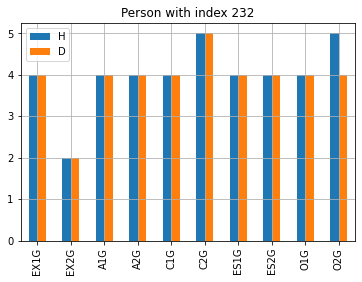

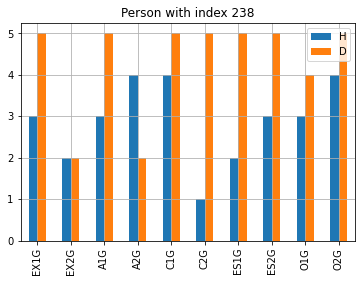

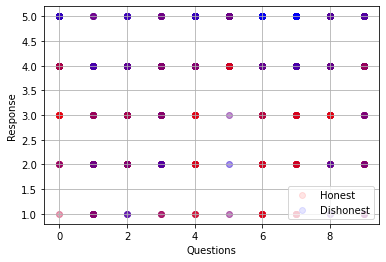

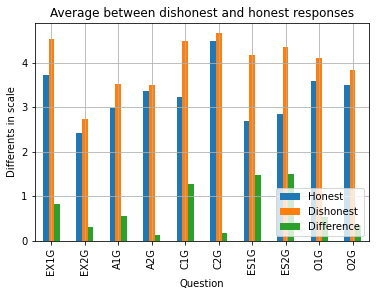

In [332]:
plot_insights(df_v, df_sample_v)

## Problem statement

Fitting SVM
Fitting Random forest
Model            Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------------  ----------------------  ----------------  ------------------------  ------------------
SVM                          0.831429       0.0141036                    0.812797           0.0505253
Random forest                0.992918       1.22772e-05                  0.829899           0.0303495


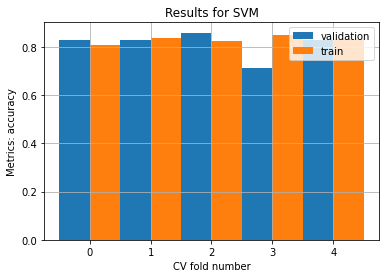

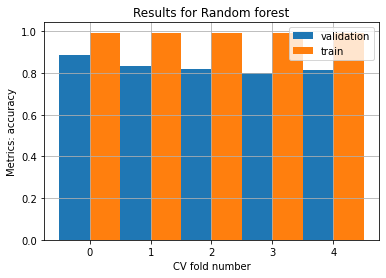

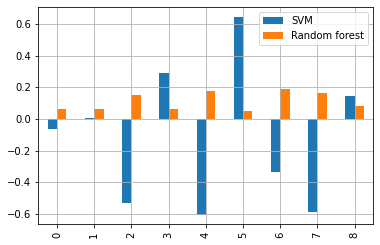

In [334]:
plot_problem_statement(df_trainval_ctu)

Fitting SVM
Fitting Random forest
Model            Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------------  ----------------------  ----------------  ------------------------  ------------------
SVM                          0.845103        0.00773952                  0.817845           0.0331757
Random forest                0.988452        0.00166078                  0.831618           0.0175557


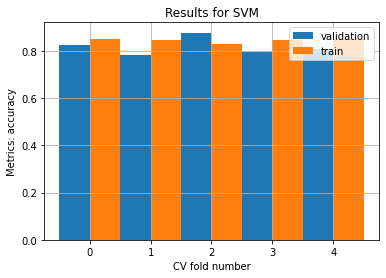

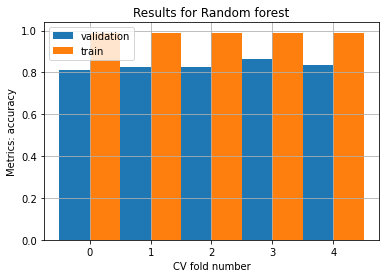

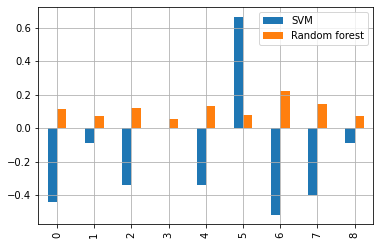

In [335]:
plot_problem_statement(df_trainval_ou)

Fitting SVM
Fitting Random forest
Model            Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------------  ----------------------  ----------------  ------------------------  ------------------
SVM                          0.823458        0.0107622                   0.801365           0.038104
Random forest                0.997424        0.00128826                  0.80666            0.0145774


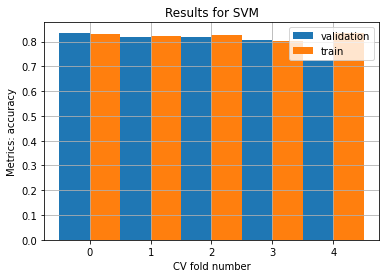

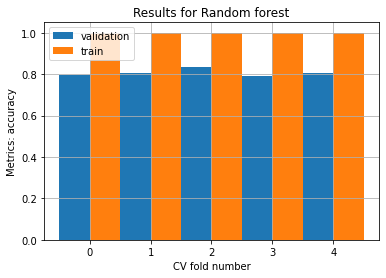

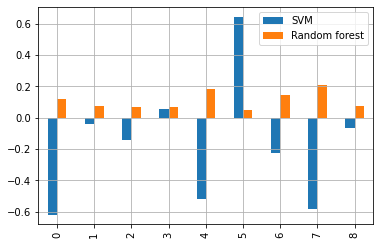

In [336]:
plot_problem_statement(df_trainval_v)